<a href="https://colab.research.google.com/github/dpetrovic89/Topic-Modeling/blob/main/Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using topic modeling to extract topics from documents

Sometimes you have a nice big set of documents, and all you wish for is to know what's hiding inside. But without reading them, of course! Two approaches to try to lazily get some information from your texts are **topic modeling** and **clustering**.

### Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **recipes.csv:** recipes - a list of recipes (but only with ingredient names)
* **state-of-the-union.csv:** State of the Union addresses - each presidential address from 1970 to 2012

In [1]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/text-analysis/data/recipes.csv -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/text-analysis/data/state-of-the-union.csv -P data

--2021-02-02 08:29:35--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/text-analysis/data/recipes.csv
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6483086 (6.2M) [text/csv]
Saving to: ‘data/recipes.csv’

recipes.csv         100%[===================>]   6.18M  25.0MB/s    in 0.2s    

2021-02-02 08:29:35 (25.0 MB/s) - ‘data/recipes.csv’ saved [6483086/6483086]

--2021-02-02 08:29:36--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/text-analysis/data/state-of-the-union.csv
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10501219 (10M) [text/csv]
Saving to: ‘data/state-of-the-union

* When you're dealing with documents, each document is (typically) about something.
* You know each document is about by looking at the words in the document.
* Documents with similar words are probably about similar things. 

We have two major options available to us: **topic modeling** and **clustering**. There's a lot of NLP nuance going on between the two, but we're going to keep it simple:

**Topic modeling** is if each document can be about **multiple topics**. There might be 100 different topics, and a document might be 30% about one topic, 20% about another, and then 50% spread out between the others.

**Clustering** is if each document should only fit into **one topic**. It's an all-or-nothing approach.

The most important part of _all of this_ is the fact that **the computer figures out these topics by itself**. You don't tell it what to do! If you're teaching the algorithm what different specific topics look like, that's **classification.** In this case we're just saying "hey computer, please figure this out!"


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# We'll be able to see more text at once
pd.set_option("display.max_colwidth", 100)

# Recipes


We're going to start with analyzing **about 36,000 recipes**. Food is interesting because you can split it so many ways: by courses, or by baked goods vs meat vs vegetables vs others, by national cuisine...

In [3]:
recipes = pd.read_csv("data/recipes.csv")
recipes.head()

,cuisine,id,ingredient_list
0,greek,10259,"romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanzo..."
1,southern_us,25693,"plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, ye..."
2,filipino,20130,"eggs, pepper, salt, mayonaise, cooking oil, green chilies, grilled chicken breasts, garlic powde..."
3,indian,22213,"water, vegetable oil, wheat, salt"
4,indian,13162,"black pepper, shallots, cornflour, cayenne pepper, onions, garlic paste, milk, butter, salt, lem..."


In order to analyze the text, we'll need to count the words in each recipe. To do that we're going to use a **stemmed TF-IDF vectorizer** from scikit-learn.

* **Stemming** will allow us to combine words like `tomato` and `tomatoes`
* Using **TF-IDF** will allow us to devalue common ingredients like salt and water

In [6]:
pip install pystemmer

     |████████████████████████████████| 563kB 5.4MB/s 
  Created wheel for pystemmer: filename=PyStemmer-2.0.1-cp36-cp36m-linux_x86_64.whl size=423590 sha256=aee0ac805cc8f71297861317a7a706d0736dddd9339aebccb0f3d225126aa496
  Stored in directory: /root/.cache/pip/wheels/f3/3c/11/ee323a09706e17a649c2730bd8819b06e887411ff7507acf7a
Successfully built pystemmer


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
import Stemmer

# English stemmer from pyStemmer
stemmer = Stemmer.Stemmer('en')

analyzer = TfidfVectorizer().build_analyzer()

# Override TfidfVectorizer
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: stemmer.stemWords(analyzer(doc))

In [8]:
vectorizer = StemmedTfidfVectorizer(min_df=50)
matrix = vectorizer.fit_transform(recipes.ingredient_list)

words_df = pd.DataFrame(matrix.toarray(),
                        columns=vectorizer.get_feature_names())
words_df.head()

,activ,adobo,agav,alfredo,all,allspic,almond,amchur,anaheim,ancho,anchovi,and,andouill,angel,anis,appl,apricot,arbol,arborio,artichok,arugula,asafetida,asafoetida,asiago,asian,asparagus,avocado,babi,back,bacon,bag,baguett,bake,balsam,bamboo,banana,barbecu,barley,base,basil,...,verd,vermicelli,vermouth,vert,vidalia,vietnames,vinaigrett,vine,vinegar,virgin,vodka,wafer,walnut,warm,wasabi,water,watercress,wedg,wheat,whip,whiskey,white,whitefish,whole,wild,wine,wing,with,wonton,worcestershir,wrapper,yam,yeast,yellow,yoghurt,yogurt,yolk,yukon,zest,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278745,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.276000,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.360903,0.0,0.0,0.757631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113503,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.210575,0.0,0.0,0.0,0.0


Looks like we have 752 ingredients! Yes, there are some numbers in there and probably other things we aren't interested in, but let's stick with it for now.

## Topic Modeling

There are multiple techniques for topic modeling, but in the end they do the same thing: **you get a list of topics, and a list of words associated with each topic.**

Let's tell it to break them down into **five topics.**

**NMF Algorithm definition** from sklearn: 

Non-Negative Matrix Factorization (NMF).

Find two non-negative matrices (W, H) whose product approximates the non- negative matrix X. This factorization can be used for example for dimensionality reduction, source separation or topic extraction.



In [9]:
from sklearn.decomposition import NMF

model = NMF(n_components=5)
model.fit(matrix)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=5, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

Why five topics? **Because we have to tell it _something_.** Our job is to decide the number of topics, and it's the computer's job to find the topics.

Fitting the model allowed it to "learn" what the ingredients are and how they're organized, we just need to find out what's inside. Let's ask for the **top ten terms in each group.**

In [10]:
n_words = 10
feature_names = vectorizer.get_feature_names()

topic_list = []
for topic_idx, topic in enumerate(model.components_):
    top_features = [feature_names[i] for i in topic.argsort()][::-1][:n_words]
    top_n = ' '.join(top_features)
    topic_list.append(f"topic_{'_'.join(top_features[:3])}") 

    print(f"Topic {topic_idx}: {top_n}")

Topic 0: oliv pepper fresh oil dri garlic salt parsley red tomato
Topic 1: flour egg sugar purpos all butter bake milk larg powder
Topic 2: sauc soy sesam rice oil ginger sugar chicken vinegar garlic
Topic 3: ground chili cilantro cumin powder lime onion pepper chop fresh
Topic 4: chees shred cream parmesan cheddar grate tortilla mozzarella sour chicken


In [12]:
print(topic_list)

['topic_oliv_pepper_fresh', 'topic_flour_egg_sugar', 'topic_sauc_soy_sesam', 'topic_ground_chili_cilantro', 'topic_chees_shred_cream']


Those actually seem like _pretty good topics_. Italian-ish, then baking, then 
Chinese, maybe Latin American or Indian food, and then dairy. What if we did it with **fifteen topics** instead?

In [13]:
model = NMF(n_components=15)
model.fit(matrix)

n_words = 10
feature_names = vectorizer.get_feature_names()

topic_list = []
for topic_idx, topic in enumerate(model.components_):
    top_n = [feature_names[i]
             for i in topic.argsort()
             [-n_words:]][::-1]
    top_features = ' '.join(top_n)
    topic_list.append(f"topic_{'_'.join(top_n[:3])}") 

    print(f"Topic {topic_idx}: {top_features}")

Topic 0: pepper bell red green onion celeri flake black tomato crush
Topic 1: flour purpos all bake powder butter soda buttermilk salt egg
Topic 2: sauc soy sesam oil ginger rice sugar garlic scallion starch
Topic 3: tortilla cream shred chees sour cheddar salsa corn bean jack
Topic 4: chees parmesan grate mozzarella pasta ricotta basil italian fresh spinach
Topic 5: lime cilantro fresh chop juic jalapeno chile avocado chili fish
Topic 6: chicken breast boneless skinless broth halv sodium low fat thigh
Topic 7: ground black pepper cumin cinnamon salt beef cayenn kosher paprika
Topic 8: chili seed powder cumin coriand masala garam curri ginger coconut
Topic 9: sugar egg vanilla milk extract larg cream butter yolk unsalt
Topic 10: oliv extra virgin oil clove garlic fresh salt tomato parsley
Topic 11: white wine vinegar rice shallot red salt grain mustard sugar
Topic 12: dri oregano tomato thyme parsley garlic bay basil leaf onion
Topic 13: lemon juic fresh orang zest parsley grate mint p

This is where we start to see **the big difference between categories and topics**. The grouping with five groups seemed very much like cuisines - Italian, Chinese, etc. But now that we're breaking it down further, the groups have changed a bit.

They're now **more like classes of ingredients.** Baking gets a category - `chicken breast boneless skinless` and so do generic Mediterranean ingredients - `oliv extra virgin oil clove garlic fresh salt`. The algorithm got a little confused about black pepper vs. hot pepper flakes vs green/yellow bell peppers when it created `pepper bell red green onion celeri flake black`, but we understand what it's going for.

Remember, the important thing about topic modeling is that every row in our dataset is a **combinations of topics**. It might be a little bit about one thing, a little bit less about another, etc etc. Let's take a look at how that works.

In [15]:
# If we don't want 'real' names for the topics, we can run this line
# topic_list = [f"topic_{i}" for i in range(model.n_components_)]

# Convert our counts into numbers
amounts = model.transform(matrix) * 100

# Set it up as a dataframe
topics = pd.DataFrame(amounts, columns=topic_list)
topics.head(15)

,topic_pepper_bell_red,topic_flour_purpos_all,topic_sauc_soy_sesam,topic_tortilla_cream_shred,topic_chees_parmesan_grate,topic_lime_cilantro_fresh,topic_chicken_breast_boneless,topic_ground_black_pepper,topic_chili_seed_powder,topic_sugar_egg_vanilla,topic_oliv_extra_virgin,topic_white_wine_vinegar,topic_dri_oregano_tomato,topic_lemon_juic_fresh,topic_water_yeast_warm
0,1.437171,0.000000,0.000000,2.677214,1.618166,0.225094,0.000000,0.506780,0.000000,0.000000,2.559301,0.000000,0.479810,0.000000,0.000000
1,2.445130,3.036020,0.176831,1.414213,0.000000,0.000000,0.000000,5.705287,0.498348,1.594436,0.548283,0.000000,1.616409,0.000000,0.245414
2,2.107602,1.670666,3.677220,0.668899,0.134084,0.000000,6.575805,0.000000,2.546529,1.091751,0.000000,0.000000,0.000000,0.112981,0.000000
3,0.019491,0.895283,0.797360,0.000000,0.000000,0.000000,0.148452,0.122314,1.032130,0.000000,1.684881,0.000000,0.000000,0.000000,8.440192
4,0.765540,0.171066,0.000000,0.446476,0.000000,0.000000,4.146199,2.665233,5.327514,1.104527,0.000000,0.055745,0.293306,3.480430,1.925490
5,0.000000,4.445598,0.808608,0.000000,0.000000,0.000000,0.000000,4.353406,2.937388,7.779426,0.000000,0.000000,0.000000,1.076620,0.000000
6,0.971150,0.081163,0.000000,0.045675,0.000000,2.810793,0.000000,0.000000,0.863145,0.000000,3.053631,3.696050,1.763309,0.000000,0.232487
7,0.000000,2.507647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.289854,6.370707,1.040987,1.934595,1.895860,0.000000,0.000000
8,0.792964,0.000000,0.000000,5.058331,0.465487,7.174156,0.000000,2.976870,0.000000,0.000000,1.726327,0.000000,0.000000,0.000000,0.098556
9,0.000000,0.000000,0.000000,0.000000,0.451619,2.114902,0.000000,0.000000,0.000000,0.000000,11.330474,0.000000,2.472211,0.201256,0.000000




Let's combine this topics dataframe with our **original dataframe** so we can see it all in one place.

In [16]:
merged = recipes.merge(topics, right_index=True, left_index=True)
merged.head(2)

,cuisine,id,ingredient_list,topic_pepper_bell_red,topic_flour_purpos_all,topic_sauc_soy_sesam,topic_tortilla_cream_shred,topic_chees_parmesan_grate,topic_lime_cilantro_fresh,topic_chicken_breast_boneless,topic_ground_black_pepper,topic_chili_seed_powder,topic_sugar_egg_vanilla,topic_oliv_extra_virgin,topic_white_wine_vinegar,topic_dri_oregano_tomato,topic_lemon_juic_fresh,topic_water_yeast_warm
0,greek,10259,"romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanzo...",1.437171,0.00000,0.000000,2.677214,1.618166,0.225094,0.0,0.506780,0.000000,0.000000,2.559301,0.0,0.479810,0.0,0.000000
1,southern_us,25693,"plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, ye...",2.445130,3.03602,0.176831,1.414213,0.000000,0.000000,0.0,5.705287,0.498348,1.594436,0.548283,0.0,1.616409,0.0,0.245414


And graph it! Let's see what our distribution of topics looks like.

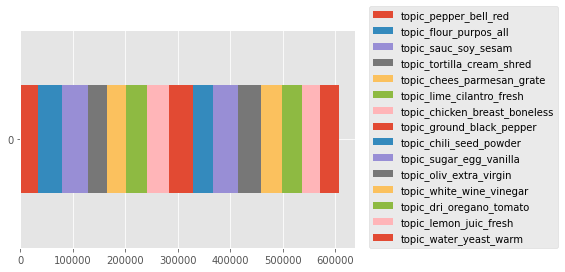

In [17]:
ax = merged[topic_list].sum().to_frame().T.plot(kind='barh', stacked=True)

# Move the legend off of the chart
ax.legend(loc=(1.04,0))

# State of the Union addresses

One of the fun things to do with topic modeling is see how **things change over time.** For this example, we're going to reproduce an assignment from [Jonathan Stray's Computational Journalism course](http://www.compjournalism.com/?p=208).

At the beginning of each year, the President of the United States traditionally addresses Congress in a speech called the State of the Union. It's a good way to judge what's important in the country at the time, because the speech is sure to be used as a platform to address the legislative agenda for the year. Let's see if topic modeling can help illustrate how it's **changed over time.**

In [24]:
speeches = pd.read_csv("data/state-of-the-union.csv")
speeches.sample(5)

,year,content
125,1914,"\nState of the Union Address\nWoodrow Wilson\nDecember 8, 1914\n\nGENTLEMEN OF THE CONGRESS:\n\n..."
23,1812,"\nState of the Union Address\nJames Madison\nNovember 4, 1812\n\nFellow-Citizens of the Senate a..."
109,1898,"\nState of the Union Address\nWilliam McKinley\nDecember 5, 1898\n\nTo the Senate and House of R..."
73,1862,"\nState of the Union Address\nAbraham Lincoln\nDecember 1, 1862\n\nFellow-Citizens of the Senate..."
24,1813,"\nState of the Union Address\nJames Madison\nDecember 7, 1813\n\nFellow-Citizens of the Senate a..."


In [25]:
speeches.shape

(226, 2)

To help the analysis out a bit, we're going to clean the text. Just remove anything that isn't a word.

In [26]:
# Remove non-word characters, so numbers and ___ etc
speeches.content = speeches.content.str.replace("[^A-Za-z ]", " ")
speeches.head()

,year,content
0,1790,George Washington January Fellow Citizens of the Senate and House of Representatives ...
1,1790,State of the Union Address George Washington December Fellow Citizens of the Senate an...
2,1791,State of the Union Address George Washington October Fellow Citizens of the Senate an...
3,1792,State of the Union Address George Washington November Fellow Citizens of the Senate an...
4,1793,State of the Union Address George Washington December Fellow Citizens of the Senate an...


### Vectorize

We're going to use the same TF-IDF vectorizer we used up above, which stems in addition to just vectorizing. We'll reproduce the code down here for easy cut-and-paste.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
import Stemmer

# English stemmer from pyStemmer
stemmer = Stemmer.Stemmer('en')

analyzer = TfidfVectorizer().build_analyzer()

# Override TfidfVectorizer
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: stemmer.stemWords(analyzer(doc))

With our first pass we'll **vectorize everything**, no limits!

In [28]:
vectorizer = StemmedTfidfVectorizer(stop_words='english')
matrix = vectorizer.fit_transform(speeches.content)

words_df = pd.DataFrame(matrix.toarray(),
                        columns=vectorizer.get_feature_names())
words_df.head()

,aaa,aana,aaron,abandon,abat,abba,abbrevi,abdic,abduct,aberdeen,abess,abet,abettor,abey,abhor,abhorr,abid,abideth,abil,abject,abjur,abl,ablaz,ablest,abli,abnorm,aboard,abod,abolish,abolit,abomin,aborigin,abort,abound,abra,abraham,abreast,abridg,abroad,abrog,...,yitzhak,ynez,yogi,yoke,yokohama,york,yorker,yorktown,yosemit,young,younger,youngest,youngster,youth,yugoslavia,yukon,zablocki,zaca,zachari,zanesvill,zanjon,zarfo,zarqawi,zeal,zealand,zealous,zelaya,zeppelin,zero,zest,zigzag,zimbabw,zimbabwean,zinc,zion,zollverein,zone,zoolog,zoom,zuloaga
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.030447,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.072037,0.026271,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045119,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.039643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.050896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.037122,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031877,0.0,0.043959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052058,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Running NME/NMF topic modeling

Now we'll leap into topic modeling. We'll look at fifteen topics, since we're covering a long span of time where lots of different things may have happened.

In [29]:
model = NMF(n_components=15)
model.fit(matrix)

n_words = 10
feature_names = vectorizer.get_feature_names()

topic_list = []
for topic_idx, topic in enumerate(model.components_):
    top_n = [feature_names[i]
             for i in topic.argsort()
             [-n_words:]][::-1]
    top_features = ' '.join(top_n)
    topic_list.append(f"topic_{'_'.join(top_n[:3])}") 

    print(f"Topic {topic_idx}: {top_features}")

Topic 0: state govern constitut unit mexico congress territori power countri shall
Topic 1: program year feder nation econom govern billion new increas develop
Topic 2: ve job american america year tonight work peopl help let
Topic 3: shall million countri vessel nation peac public necessari citizen time
Topic 4: govern nation law great men peopl need interst work countri
Topic 5: govern agricultur nation feder industri public countri year bank congress
Topic 6: year state increas report law unit cent offic congress secretari
Topic 7: terrorist iraq america iraqi terror al tonight american help afghanistan
Topic 8: govern bank public state duti countri subject treasuri peopl general
Topic 9: state gentlemen unit nation public law measur indian provis object
Topic 10: govern state unit treati american countri relat congress convent intern
Topic 11: war enemi victori fight japanes american british forc command nation
Topic 12: world nation soviet peac free peopl freedom defens econom war

So many of these words are so _common_ that it doesn't do much to convince me these are meaningful concepts.

### Adjusting our min and max document frequency

One way to cut those overly broad topics from our topic model is to **remove them from the vectorizer.** Instead of accepting _all_ words, we can set minimum or maximum limits.

Let's only accept words used **in at least 5 speeches**, but also **don't appear in more than half of the speeches**.

In [30]:
vectorizer = StemmedTfidfVectorizer(stop_words='english', min_df=5, max_df=0.5)
matrix = vectorizer.fit_transform(speeches.content)

words_df = pd.DataFrame(matrix.toarray(),
                        columns=vectorizer.get_feature_names())
words_df.head()

,abandon,abat,abdic,abey,abhorr,abid,ablest,abli,abnorm,aboard,abod,abolish,abolit,aborigin,abort,abound,abraham,abreast,abridg,abrog,abrupt,absenc,absent,absolut,absolv,absorb,absorpt,abstain,abstin,abstract,absurd,abund,abus,academ,academi,acced,acceler,accentu,access,accessori,...,wors,worship,worst,worth,worthless,wouldn,wound,wrath,wreck,wrest,wretch,wright,writ,write,writer,written,wrong,wrongdo,wrongdoer,wrote,wrought,wyom,yard,yearn,yellow,yellowston,yes,yesterday,yield,york,young,younger,youngest,youth,yukon,zeal,zealand,zealous,zero,zone
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.060651,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.099321,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.133821,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.062207,0.0,0.000000,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031997,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.080205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03415,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.061534,0.0,0.0
3,0.0,0.076291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.047783,0.0,0.065893,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081375,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.041906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.03836,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


In [31]:
model = NMF(n_components=15)
model.fit(matrix)

n_words = 10
feature_names = vectorizer.get_feature_names()

topic_list = []
for topic_idx, topic in enumerate(model.components_):
    top_n = [feature_names[i]
             for i in topic.argsort()
             [-n_words:]][::-1]
    top_features = ' '.join(top_n)
    topic_list.append(f"topic_{'_'.join(top_n[:3])}") 

    print(f"Topic {topic_idx}: {top_features}")

Topic 0: cent pension island commission cuba silver arbitr diplomat consular spain
Topic 1: ve job tonight budget cut spend ll school deficit don
Topic 2: spain coloni articl intercours likewis tribe port augment commenc florida
Topic 3: program billion today budget goal area level farm inflat percent
Topic 4: corpor interst forest island philippin railroad canal supervis panama standpoint
Topic 5: terrorist iraq iraqi terror al tonight afghanistan regim qaeda fight
Topic 6: mexico texa mexican oregon california annex articl steamer postag levi
Topic 7: currenc silver gold circul note speci paper coin deposit coinag
Topic 8: method veteran cent board tariff farmer consolid depress farm railway
Topic 9: gentlemen commission articl majesti philadelphia amiti croix agreeabl captur tranquil
Topic 10: militia enemi tribe council port disposit legislatur ensu neutral whilst
Topic 11: fight enemi democraci japanes victori today task tank plane nazi
Topic 12: soviet communist atom aggress kore

Lots of references to wars and political conflict, along with slavery and monetary policy.

## Visualizing the outcome

We can get a better handle on what our data looks like through a little visualization. We'll start by loading up the **topic popularity dataframe**. Remember that each row is one of our speeches.

In [32]:
# Convert our counts into numbers
amounts = model.transform(matrix) * 100

# Set it up as a dataframe
topics = pd.DataFrame(amounts, columns=topic_list)
topics.head(2)

,topic_cent_pension_island,topic_ve_job_tonight,topic_spain_coloni_articl,topic_program_billion_today,topic_corpor_interst_forest,topic_terrorist_iraq_iraqi,topic_mexico_texa_mexican,topic_currenc_silver_gold,topic_method_veteran_cent,topic_gentlemen_commission_articl,topic_militia_enemi_tribe,topic_fight_enemi_democraci,topic_soviet_communist_atom,topic_kansa_slave_slaveri,topic_vietnam_tonight_billion
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.308307,0.0,30.551262,7.726144,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,22.778823,23.201642,0.0,0.0,0.0,0.990691


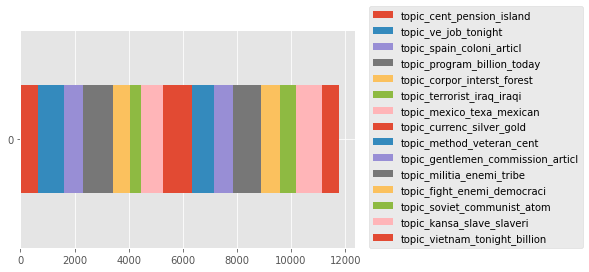

In [33]:
ax = topics.sum().to_frame().T.plot(kind='barh', stacked=True)

# Move the legend off of the chart
ax.legend(loc=(1.04,0))

Again, pretty even! A few are larger or smaller, but overall the topics seem pretty evenly distributed.

Looking at things over all time doesn't mean much, though, we're interseted in **change over time**.

The hip way to do this is with a **streamgraph**, which is a stacked area graph that centers on the vertical axis. Usually you'd have to merge the two dataframes in order to graph, but we can sneakily get around it since we aren't plotting with pandas (plotting streamgraphs requires directly talking to matplotlib).

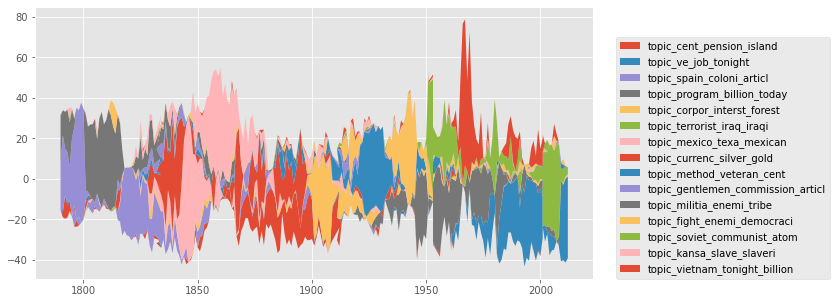

In [34]:
x_axis = speeches.year
y_axis = topics

fig, ax = plt.subplots(figsize=(10,5))

# Plot a stackplot - https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/stackplot_demo.html
ax.stackplot(x_axis, y_axis.T, baseline='wiggle', labels=y_axis.columns)

# Move the legend off of the chart
ax.legend(loc=(1.04,0))

I know that "Presidents talk about current news topics" is probably not the most exciting things you've ever seen, but you can watch things rise and fall easily enough.

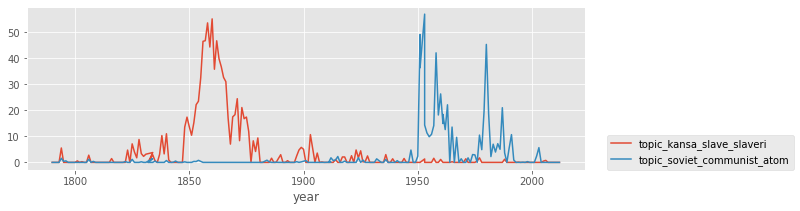

In [35]:
merged = topics.join(speeches)

ax = merged.plot(x='year', y=['topic_kansa_slave_slaveri', 'topic_soviet_communist_atom'], figsize=(10,3))
ax.legend(loc=(1.04,0))

we looked at **topic modeling**, a technique of extracting topics out of text datasets. Unlike clustering, where each document is assigned one category, in topic modeling **each document is considered blend of different topics.**

You don't need to "teach" a topic model anything about your dataset, you just let it loose and it comes back with what terms represent each topic. The only thing you need to give it is the **number of topics to find**.

The way you preprocess the text is very important to a topic model. We found that common words ended up appearing in many topics unless we used `max_df=` in our vectorizer to filter out high-frequency words.